# Performance Test

## Verify Fixed Disclosure from Variable Attribute Schema

### Imports

In [1]:
from aries_cloudcontroller import AriesAgentController

from libs.performance_service import PerformanceService
import os
import time
from termcolor import colored

### Initialise the Agent Controller

In [2]:
api_key = os.getenv("ACAPY_ADMIN_API_KEY")
admin_url = os.getenv("ADMIN_URL")

print(f"Initialising a controller with admin api at {admin_url} and an api key of {api_key}")
agent_controller = AriesAgentController(admin_url,api_key)

Initialising a controller with admin api at http://verifier-agent:3021 and an api key of adminApiKey


### Start a Webhook Server

In [3]:
webhook_port = int(os.getenv("WEBHOOK_PORT"))
webhook_host = "0.0.0.0"

await agent_controller.init_webhook_server(webhook_host, webhook_port)

print(f"Listening for webhooks from agent at http://{webhook_host}:{webhook_port}")

Listening for webhooks from agent at http://0.0.0.0:3010


## Store Issuing Schema and Cred Def Identifiers

If you intend for this agent to issue credentials you should first initialise your agent as an issuer and author the relevant identifiers to the public ledger. The issuer_initialisation recipe notebook can be duplicated and used as a starting point.

Once schema and cred def identifiers are created copy across and store in variables as illustrated in the cell below. Be sure to use unique names for each variable.

In [4]:
one_schema_id='H7zAaLJRZrdbPqbVMMfL5t:2:one-attrib:0.0.2'
one_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:15:default'
one_rev_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:15:revocable'

five_schema_id='H7zAaLJRZrdbPqbVMMfL5t:2:five-attrib:0.0.1'
five_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:16:default'
five_rev_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:16:revocable'

ten_schema_id='H7zAaLJRZrdbPqbVMMfL5t:2:ten-attrib:0.0.1'
ten_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:17:default'
ten_rev_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:17:revocable'

twenty_schema_id='H7zAaLJRZrdbPqbVMMfL5t:2:twenty-attrib:0.0.1'
twenty_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:18:default'
twenty_rev_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:18:revocable'

fifty_schema_id='H7zAaLJRZrdbPqbVMMfL5t:2:fifty-attrib:0.0.1'
fifty_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:19:default'
fifty_rev_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:19:revocable'

hundred_schema_id='H7zAaLJRZrdbPqbVMMfL5t:2:hundred-attrib:0.0.1'
hundred_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:20:default'
hundred_rev_cred_def_id='H7zAaLJRZrdbPqbVMMfL5t:3:CL:20:revocable'



## Init Performance Service

In [5]:
performance_service = PerformanceService(agent_controller, iterations=100)

## Establish Connection

Before you can issue a credential you must first establish a connection across which the credential will be issued to a holder. (see recipes/connection)

In [6]:
# Alias for invited connection
alias = "Friend"
auto_accept = "true"
# Use public DID?
public = "false"
# Should this invitation be usable by multiple invitees?
multi_use = "false"

invitation_response = await agent_controller.connections.create_invitation(alias, auto_accept, public, multi_use)
# Is equivalent to above. Arguments are optionally
# invitation_response = await agent_controller.connections.create_invitation()



# You will use this identifier to issue a credential across this connection
connection_id = invitation_response["connection_id"]

invitation = invitation_response["invitation"]
## Copy this output
print(invitation)
print(connection_id)

{'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/connections/1.0/invitation', '@id': 'eb11d20d-eb3f-4147-9b27-df23e2b87376', 'serviceEndpoint': 'http://verifier-agent:3020', 'recipientKeys': ['6LrnLy49Ni63FHx5xBRwD9r5EhQwjuYqHHcV17VGUian'], 'label': 'Verifier'}
aa31be98-f92b-41b3-a464-79f041275849


In [7]:
connection_id = "3aaf07e2-d41b-4dff-903d-6acc4b21c3af"

## Define Presentation Request Object


In [8]:
proof_request = {
    "name": "Name of Proof Request",
    "version": "1.0",

    # Predicates allow us to specify range proofs or set membership on attributes. For example greater than 10.
    # We will ignore these for now.
    "requested_predicates": {
#         f"0_{req_pred['name']}_GE_uuid":
#         req_pred for req_pred in req_preds
    },
    # You can also request the entire proof request be non-revoked
    "non_revoked":  {"to": int(time.time())}
}

# Single Disclosed Attribute from Variable Size Credential Experiment


In [9]:
experiment = performance_service.new_experiment("Single Attribute from Variable Credentials - Non Revocable")


In [10]:
revocable_experiment = performance_service.new_experiment("Single Attribute from Variable Credential - Revocable")

## Performance Test - One Attribute Credential

In [11]:
req_attrs = [
    {"name": "1", "restrictions": [{"schema_id": one_schema_id, "cred_def_id": one_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [12]:
name = "1"

In [13]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(experiment, test, connection_id)

Average :  0.31204176397015543


In [14]:
req_attrs = [
    {"name": "1", "restrictions": [{"schema_id": one_schema_id, "cred_def_id": one_rev_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [15]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(revocable_experiment, test, connection_id)

Average :  1.0849647952197847


## Performance Test - Five Attribute Credential

In [16]:
req_attrs = [
    {"name": "1", "restrictions": [{"schema_id": five_schema_id, "cred_def_id": five_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [17]:
name = "5"

In [18]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(experiment, test, connection_id)

Average :  0.38819501604019024


In [19]:
req_attrs = [
    {"name": "1", "restrictions": [{"schema_id": five_schema_id, "cred_def_id": five_rev_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [20]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(revocable_experiment, test, connection_id)

Average :  1.0826870859800692


## Performance Test - Ten Attribute Credential

In [21]:
req_attrs = [
    {"name": "1", "restrictions": [{"schema_id": ten_schema_id, "cred_def_id": ten_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [22]:
name = "10"

In [23]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(experiment, test, connection_id)

Average :  0.3906349734297328


In [24]:
req_attrs = [
    {"name": "1", "restrictions": [{"schema_id": ten_schema_id, "cred_def_id": ten_rev_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [25]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(revocable_experiment, test, connection_id)

Average :  1.1447029979201033


## Performance Test - Twenty Attribute Credential

In [26]:
req_attrs = [
    {"name": "1", "restrictions": [{"schema_id": twenty_schema_id, "cred_def_id": twenty_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [27]:
name = "20"

In [28]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(experiment, test, connection_id)

Average :  0.6059880108198559


In [29]:
req_attrs = [
    {"name": "1", "restrictions": [{"schema_id": twenty_schema_id, "cred_def_id": twenty_rev_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [30]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(revocable_experiment, test, connection_id)

Average :  1.177648461190147


## Performance Test - Fifty Attribute Credential

In [31]:
req_attrs = [
    {"name": "1", "restrictions": [{"schema_id": fifty_schema_id, "cred_def_id": fifty_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [32]:
name = "50"

In [33]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(experiment, test, connection_id)

Average :  0.6991257308398781


In [34]:
req_attrs = [
    {"name": "1", "restrictions": [{"schema_id": fifty_schema_id, "cred_def_id": fifty_rev_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [35]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(revocable_experiment, test, connection_id)

Average :  1.3821254891599528


## Performance Test - Hundred Attribute Credential

In [36]:
req_attrs = [
    {"name": "1", "restrictions": [{"schema_id": hundred_schema_id, "cred_def_id": hundred_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [37]:
name = "100"

In [38]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(experiment, test, connection_id)

Average :  0.9033805357198799


In [39]:
req_attrs = [
    {"name": "1", "restrictions": [{"schema_id": hundred_schema_id, "cred_def_id": hundred_rev_cred_def_id}]},
]

proof_request["requested_attributes"] = {
        # They generally follow this uuid pattern. Unique identifier for attribute within context of this proof request
        # Note that req_attr['name'] gets the attribute name of each object. E.g. domain and name in this case
        f"0_{req_attr['name']}_uuid":
        req_attr for req_attr in req_attrs
}

In [40]:
test = {"name": name, "proof_request": proof_request}

await performance_service.run_verification(revocable_experiment, test, connection_id)

Average :  1.675720763590216


## Plot Results

### Non Revocable

In [49]:
data = []
labels = []
non_revocable_averages = []
for result in experiment["results"]:
    
    millitimings = [i * 1000 for i in result["timings"]]
    data.append(millitimings)
    non_revocable_averages.append(result["average"] * 1000)
    labels.append(result["name"])



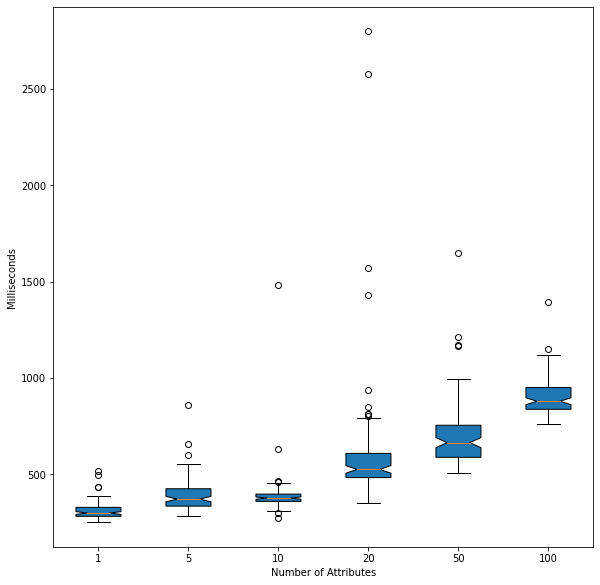

In [50]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 

 
fig = plt.figure(figsize =(10, 10))
 
# Creating axes instance
ax = fig.add_axes([0.1,0.1,0.75,0.75]) 
 
# Creating plot`
bp = ax.boxplot(data, patch_artist = True,
                notch ='True')

# x-axis labels
ax.set_xticklabels(labels)

plt.ylabel("Milliseconds")
plt.xlabel("Number of Attributes")

plt.savefig("results/verification/fixed_disclosure_variable_attrib_number/box_plot_non_revocable.png")

### Revocable

In [51]:
data = []
labels = []
revocable_averages = []
for result in revocable_experiment["results"]:
    
    millitimings = [i * 1000 for i in result["timings"]]
    data.append(millitimings)
    revocable_averages.append(result["average"] * 1000)
    labels.append(result["name"])
    


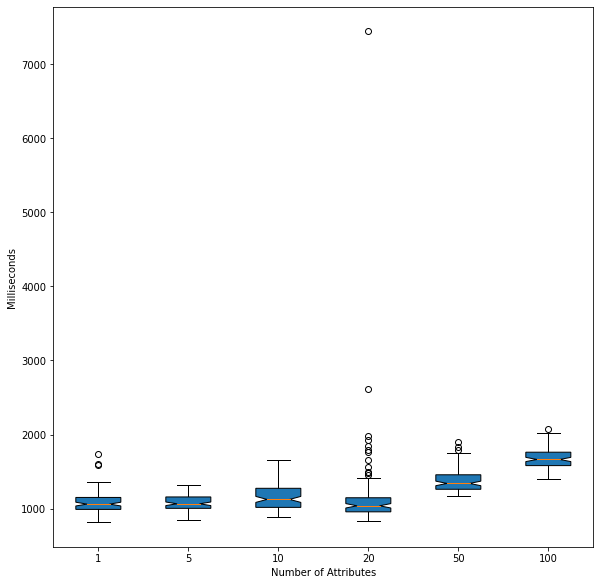

In [52]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
 

 
fig = plt.figure(figsize =(10, 10))
 
# Creating axes instance
ax = fig.add_axes([0.1,0.1,0.75,0.75]) 
 
# Creating plot`
bp = ax.boxplot(data, patch_artist = True,
                notch ='True')

# x-axis labels
ax.set_xticklabels(labels)

plt.ylabel("Milliseconds")
plt.xlabel("Number of Attributes")

plt.savefig("results/verification/fixed_disclosure_variable_attrib_number/box_plot_revocable.png")

## Averages

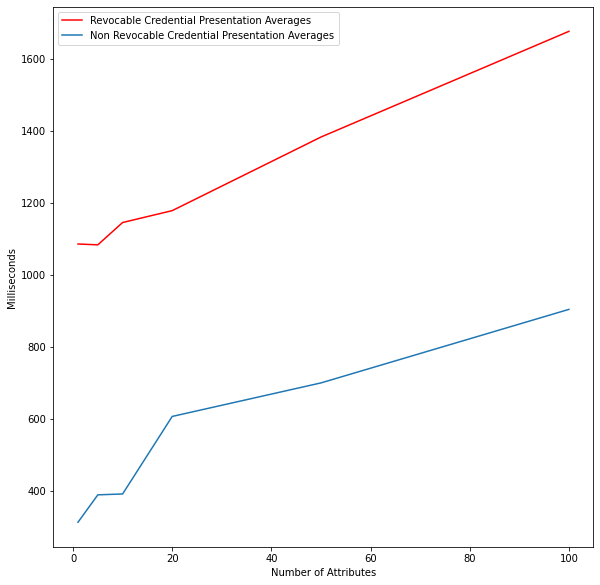

In [54]:
fig = plt.figure(figsize =(10, 10))
 
# Creating axes instance
ax = fig.add_axes([0.1,0.1,0.75,0.75]) 

# avg_ploy = plt.plot(labels, revocable_averages, non_revoked_averages)

plt_points = [1,5,10,20,50,100]

plt.plot(plt_points, revocable_averages,'r-',label='Revocable Credential Presentation Averages')
plt.plot(plt_points, non_revocable_averages,label='Non Revocable Credential Presentation Averages')

plt.ylabel("Milliseconds")
plt.xlabel("Number of Attributes")


plt.legend()
plt.savefig("results/verification/fixed_disclosure_variable_attrib_number/averages.png")

## Save Experiments to File

In [56]:
performance_service.save_experiments()

## Terminate Controller

Whenever you have finished with this notebook, be sure to terminate the controller. This is especially important if your business logic runs across multiple notebooks.

In [55]:
await agent_controller.terminate()